In [178]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import exponnorm
from scipy.optimize import curve_fit, minimize
import scipy
from scipy.interpolate import interp1d
import scipy.optimize as optimize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
data = pd.read_excel("TACs.xlsx", sheet_name=None)
relevant_keys = ['PT 300 ml Qclear 2', 'PT 300 ml Qclear 1', 'PT 200 ml Qclear 2', 'PT 200 ml Qclear 1', 'PT 100 ml Qclear 2', 'PT 100 ml Qclear 1']
qclear = [2, 1, 2, 1, 2, 1]
sizes = [300, 300, 200, 200, 100, 100]

In [3]:
frames = []
for key, clear, size in zip(relevant_keys, qclear, sizes):
    frame = data[key]
    df = frame.loc[5:]
    df.columns = ["time", "input", "tissue"]
    df[['time_start', 'time_end']] = df['time'].str.split(' - ', 1, expand=True)
    df["sample"] = clear
    df["flow"] = size
    df = df.astype({'input': 'float64', 'tissue': 'float64', 'time_start': 'int32', 'time_end': 'int32'})
    df = df.drop(["time"], axis=1)
    df["midpoint"] = (df["time_end"] + df["time_start"]) / 2
    frames.append(df)
df = pd.concat(frames)

/home/mikael/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/mikael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/mikael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [4]:
maxes = []
sizes = []
samples = []
input_integrals = []
tissue_integrals = []
colors = ["k", "b", "r", "c", "g", "m"]
names = []
input_maxes = []
input_x_maxes = []
tissue_x_maxes = []
stds = []
skewnesses = []
means = []
for name, group in df.groupby(['sample', 'flow']):
    sizes.append(group["flow"].iloc[0])
    q = group["sample"].iloc[1]
    if q == 1:
        samples.append(1)
    else:
        samples.append(2)
    cubic_tissue = interp1d(group["midpoint"], group["tissue"], kind='cubic')
    cubic_input = interp1d(group["midpoint"], group["input"], kind='cubic')

    min_inter, max_inter = min(group["midpoint"]), max(group["midpoint"])
    xnew = np.linspace(min_inter, max_inter, num=400, endpoint=True)
    #plt.title("Cubic splines")
    #plt.plot(group["midpoint"], group["input"], 'o', xnew, cubic_input(xnew), '-')
    
    
    
    integral = np.trapz(group["input"], x=group["midpoint"])
    input_integrals.append(integral)
    
    integral = np.trapz(group["tissue"], x=group["midpoint"])
    tissue_integrals.append(integral)
    
    names.append(name)
    bounds = [(min_inter+1, max_inter-1)]
    
    results = optimize.minimize(lambda x: -cubic_input(x), x0=(100), bounds = bounds)
    input_x_maxes.append(results["x"][0])
    input_maxes.append(-results["fun"][0])
    
    results = optimize.minimize(lambda x: -cubic_tissue(x), x0=(100), bounds = bounds)
    tissue_x_maxes.append(results["x"][0])
    maxes.append(-results["fun"][0])

    indx = np.argmax(group["input"] > np.max(group["input"]) * 0.20)
    
    standard_dev = np.std(group["tissue"])
    skewness = scipy.stats.skew(group["tissue"])
    
    stds.append(standard_dev)
    skewnesses.append(skewness)
    means.append(np.mean(group["tissue"]))
    
    
    #plt.savefig("cubic_splines.jpg")

feature_df = pd.DataFrame({
    "flow": sizes,
    "tissue_max": maxes,
    "tissue_x_max": tissue_x_maxes,
    "sample": samples,
    "input_integral": input_integrals,
    "tissue_integral": tissue_integrals,
    "input_max": input_maxes,
    "input_x_max": input_x_maxes,
    "std": stds,
    "skewness": skewnesses,
    "mean": means
})
feature_df["peak_time_difference"] = feature_df["tissue_x_max"] - feature_df["input_x_max"]
df = pd.merge(df, feature_df, how="left", on=["flow", "sample"])
df

/home/mikael/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


,input,tissue,time_start,time_end,sample,flow,midpoint,tissue_max,tissue_x_max,input_integral,tissue_integral,input_max,input_x_max,std,skewness,mean,peak_time_difference
0,1.456478e+03,407.96191,0,5,2,300,2.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
1,1.278932e+03,459.05683,5,10,2,300,7.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
2,2.265328e+04,646.44457,10,15,2,300,12.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
3,4.574733e+05,10505.08901,15,20,2,300,17.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
4,1.643083e+06,89934.22971,20,25,2,300,22.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.392625e+06,784895.39999,140,160,1,100,150.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
140,6.902623e+05,925024.12368,160,190,1,100,175.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
141,2.563172e+05,870937.93689,190,220,1,100,205.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
142,7.789175e+04,634442.87209,220,250,1,100,235.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009


In [5]:
def get_interpolated_sample(start, stop, data, samples, variables, x_axis_var):
    x = np.linspace(start, stop, samples)
    samples = []
    for var in variables:
        spline = interp1d(data[x_axis_var], data[var], kind='cubic')
        samples.append(spline(x))
    return x, samples

In [6]:
df["scaled_tissue"] = df["tissue"] / df["tissue_integral"]

In [7]:
x_s, sampled_scaled_tissue = [], []
samples, flows = [], []
num_samples = 400
for name, group in df.groupby(['sample', 'flow']):
    results = get_interpolated_sample(min(df["midpoint"]), max(df["midpoint"]), group, num_samples, ["tissue"], "midpoint")
    x_s.append(results[0])
    sampled_scaled_tissue.append(results[1][0])
    samples.append(group["sample"].iloc[0])
    flows.append(group["flow"].iloc[0])

sampled_dict = {
    "s_tissue": [item for sublist in sampled_scaled_tissue for item in sublist],
    "x": [item for sublist in x_s for item in sublist],
    "flow": np.repeat(flows, num_samples),
    "sample": np.repeat(samples, num_samples)
}
sampled_df = pd.DataFrame(sampled_dict)
sampled_df

,s_tissue,x,flow,sample
0,1267.153700,2.500000,100,1
1,1273.490647,3.157895,100,1
2,1279.556715,3.815789,100,1
3,1285.391132,4.473684,100,1
4,1291.033128,5.131579,100,1
...,...,...,...,...
2395,1363.173618,262.368421,300,2
2396,1359.801763,263.026316,300,2
2397,1356.279327,263.684211,300,2
2398,1352.601887,264.342105,300,2


In [8]:
sampled_df = pd.merge(sampled_df, feature_df, how="inner", on=["sample", "flow"])
sampled_df

,s_tissue,x,flow,sample,tissue_max,tissue_x_max,input_integral,tissue_integral,input_max,input_x_max,std,skewness,mean,peak_time_difference
0,1267.153700,2.500000,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
1,1273.490647,3.157895,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
2,1279.556715,3.815789,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
3,1285.391132,4.473684,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
4,1291.033128,5.131579,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,1363.173618,262.368421,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
2396,1359.801763,263.026316,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
2397,1356.279327,263.684211,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
2398,1352.601887,264.342105,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079


In [194]:
df["scaled_x"] = df["midpoint"] - df["input_x_max"]

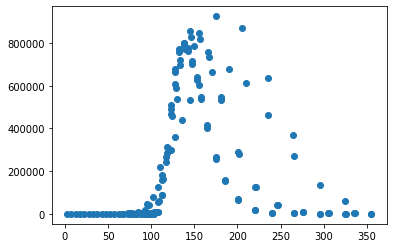

In [105]:

plt.scatter(df["scaled_x"], df["tissue"])

In [192]:
selected = df[df["flow"] == 200]
selected = selected[selected["sample"] == 2]

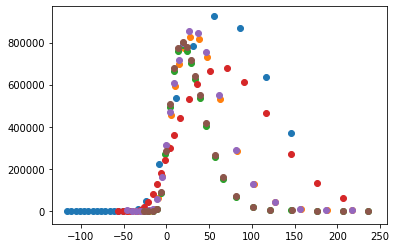

In [195]:
for name, group in df.groupby(['sample', 'flow']):
    plt.scatter(group["scaled_x"], group["tissue"])

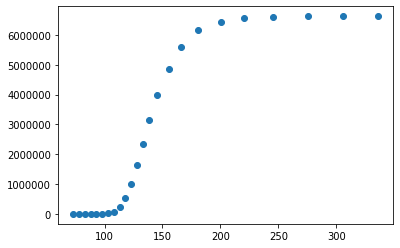

In [162]:
plt.scatter(selected["scaled_x"], selected["cum"])

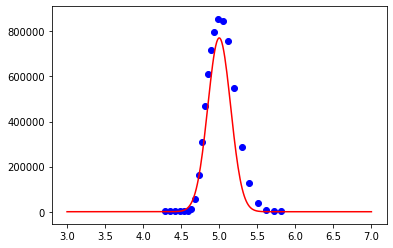

In [149]:
x_range = np.linspace(3, 7, 300)
y_s = 80000 * np.exp(-x_range ** 2)

y_s = normal_dist(5, 0.15, x_range, 290000)
plt.plot(x_range, y_s, color="r")
plt.scatter(np.log(selected["scaled_x"]), selected["tissue"], color="b")

In [115]:
def normal_dist(mu, sigma, x, h):
    return h * 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-1/2 * ((x-mu) / sigma) ** 2)

In [114]:
normal_dist(0, 1, 0)

0.3989422804014327

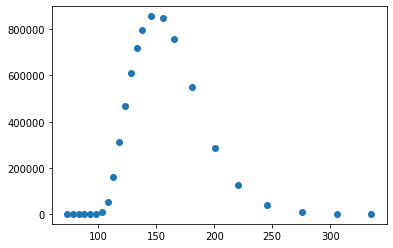

In [173]:
plt.scatter(selected["scaled_x"], selected["tissue"])

In [176]:
fit = smf.ols('np.log(tissue) ~ scaled_x', data=selected).fit()
y_pred = fit.predict(df)
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:         np.log(tissue)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                   0.01071
Date:                Tue, 26 Oct 2021   Prob (F-statistic):              0.919
Time:                        15:46:56   Log-Likelihood:                -55.718
No. Observations:                  24   AIC:                             115.4
Df Residuals:                      22   BIC:                             117.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.6431      1.242      8.569      0.0

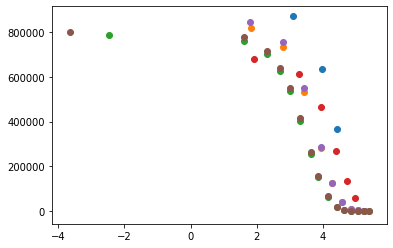

In [43]:
for name, group in df.groupby(['sample', 'flow']):
    plt.scatter(np.log(group["scaled_x"]), group["tissue"])

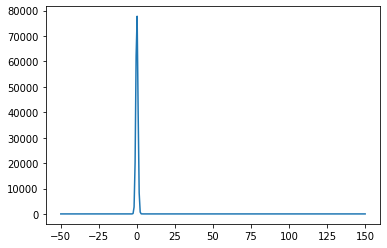

In [35]:
x_range = np.linspace(-50, 150, 300)
y_s = 80000 * np.exp(-x_range ** 2)
plt.plot(x_range, y_s)

In [31]:
selected = df[df["flow"] == 200]
selected = selected[selected["sample"] == 2]

,input,tissue,time_start,time_end,sample,flow,midpoint,tissue_max,tissue_x_max,input_integral,tissue_integral,input_max,input_x_max,std,skewness,mean,peak_time_difference,scaled_tissue,scaled_x
48,2.341358e+03,2068.20955,0,5,2,200,2.5,862367.856082,78.895128,8.260553e+07,6.188868e+07,2.476852e+06,48.214937,320526.422085,0.701743,276009.680701,30.680192,0.000033,-76.395128
49,2.338813e+03,1968.64946,5,10,2,200,7.5,862367.856082,78.895128,8.260553e+07,6.188868e+07,2.476852e+06,48.214937,320526.422085,0.701743,276009.680701,30.680192,0.000032,-71.395128
50,2.481032e+03,1955.42995,10,15,2,200,12.5,862367.856082,78.895128,8.260553e+07,6.188868e+07,2.476852e+06,48.214937,320526.422085,0.701743,276009.680701,30.680192,0.000032,-66.395128
51,3.222328e+03,1942.72058,15,20,2,200,17.5,862367.856082,78.895128,8.260553e+07,6.188868e+07,2.476852e+06,48.214937,320526.422085,0.701743,276009.680701,30.680192,0.000031,-61.395128
52,3.106694e+03,1984.02400,20,25,2,200,22.5,862367.856082,78.895128,8.260553e+07,6.188868e+07,2.476852e+06,48.214937,320526.422085,0.701743,276009.680701,30.680192,0.000032,-56.395128
53,4.652833e+04,2424.42607,25,30,2,200,27.5,862367.856082,78.895128,8.260553e+07,6.188868e+07,2.476852e+06,48.214937,320526.422085,0.701743,276009.680701,30.680192,0.000039,-51.395128
54,4.267846e+05,10909.85850,30,35,2,200,32.5,862367.856082,78.895128,8.260553e+07,6.188868e+07,2.476852e+06,48.214937,320526.422085,0.701743,276009.680701,30.680192,0.000176,-46.395128
55,1.300767e+06,55538.44663,35,40,2,200,37.5,862367.856082,78.895128,8.260553e+07,6.188868e+07,2.476852e+06,48.214937,320526.422085,0.701743,276009.680701,30.680192,0.000897,-41.395128
56,2.122924e+06,160895.63291,40,45,2,200,42.5,862367.856082,78.895128,8.260553e+07,6.188868e+07,2.476852e+06,48.214937,320526.422085,0.701743,276009.680701,30.680192,0.002600,-36.395128
57,2.471563e+06,310910.49684,45,50,2,200,47.5,862367.856082,78.895128,8.260553e+07,6.188868e+07,2.476852e+06,48.214937,320526.422085,0.701743,276009.680701,30.680192,0.005024,-31.395128


In [13]:
df["scaled_x"] = df["midpoint"] - df["tissue_x_max"]

In [14]:
df

,input,tissue,time_start,time_end,sample,flow,midpoint,tissue_max,tissue_x_max,input_integral,tissue_integral,input_max,input_x_max,std,skewness,mean,peak_time_difference,scaled_tissue,scaled_x
0,1.456478e+03,407.96191,0,5,2,300,2.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079,0.000010,-44.974071
1,1.278932e+03,459.05683,5,10,2,300,7.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079,0.000011,-39.974071
2,2.265328e+04,646.44457,10,15,2,300,12.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079,0.000016,-34.974071
3,4.574733e+05,10505.08901,15,20,2,300,17.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079,0.000263,-29.974071
4,1.643083e+06,89934.22971,20,25,2,300,22.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079,0.002248,-24.974071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.392625e+06,784895.39999,140,160,1,100,150.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009,0.007190,-32.669720
140,6.902623e+05,925024.12368,160,190,1,100,175.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009,0.008473,-7.669720
141,2.563172e+05,870937.93689,190,220,1,100,205.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009,0.007978,22.330280
142,7.789175e+04,634442.87209,220,250,1,100,235.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009,0.005811,52.330280


In [37]:
fit = smf.ols('np.log(tissue) ~ scaled_x ** 2', data=df).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:         np.log(tissue)   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 26 Oct 2021   Prob (F-statistic):                nan
Time:                        14:44:45   Log-Likelihood:                    nan
No. Observations:                 144   AIC:                               nan
Df Residuals:                     142   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept        -inf        nan        nan        n

In [ ]:
exponnorm.fit(selected["ss_tissue"])

In [ ]:
def EMG(x, mu, sigma, lambda_, h):
    #TODO : muuta rajoitus pois
    if sigma <= 1e-3:
        sigma = 1e-3
    def special_error_function(x):
        temp = scipy.special.erfc(x)
        if temp < 1e-5:
            return 0
        else:
            return temp
    def formula(x, mu, sigma):
        result=(lambda_/2) * np.exp((lambda_/2) * (2*mu + lambda_*sigma*sigma - 2*x)) * scipy.special.erfc((mu + lambda_*sigma*sigma-x) / (np.sqrt(2)*sigma))
        return result
    def formula1(x, mu, sigma):
        tau = 1 / lambda_
        if tau <= 1e-3:
            tau = 1e-3
        z = (1 / np.sqrt(2)) * ((sigma / tau) - ((x - mu) / sigma))
        if z < 0:
            val = ((sigma) / tau) * np.sqrt(np.pi / 2) * np.exp(0.5 * (sigma / tau)**2 - ((x - mu) / tau)) * scipy.special.erfc(z)
        elif z < 6.71*10**7:
            val = np.exp(-0.5 * ((x - mu) / sigma)**2) * (sigma/tau) *  np.sqrt(np.pi / 2) * scipy.special.erfcx(z)
        else:
            val = np.exp(-0.5 * ((x - mu) / sigma)**2) / (1 + (((x  -mu) * tau) / sigma**2))
        return val
    #y = np.asarray([formula(x_, mu, sigma, tau) for x_ in x])
    y = np.asarray([formula1(x_, mu, sigma) for x_ in x])

    return h * y

In [ ]:
def EMG_loss(params):
    df1 = df
    h_fit = smf.ols('tissue_max ~ input_max + input_max : integral - 1', data=feature_df).fit()
    df1["predicted_h"] = h_fit.predict(df)
    errors = []
    groups = df1.groupby(["flow", "sample"])
    for i, group in groups:
        mu = (group["input_x_max"] + params[0] * 1000 / group["flow"]).iloc[0]
        h = group["predicted_h"].iloc[0]
        emg_vals = EMG(group["midpoint"], mu, params[1], params[2], h)
        #print(np.isnan(emg_vals).any())
        error = np.sum((group["tissue"] - emg_vals) ** 2)
        errors.append(error)
    return sum(errors)

In [ ]:
def EMG_loss(params, data):
    errors = []
    groups = data.groupby(["flow", "sample"])
    for i, group in groups:
        mu = (group["input_x_max"] + params[0] * 1000 / group["flow"]).iloc[0]
        h = params[3]
        emg_vals = EMG(group["x"], mu, params[1], params[2], h)
        #print(np.isnan(emg_vals).any())
        error = np.sum((group["ss_tissue"] - emg_vals) ** 2)
        errors.append(error)
    return sum(errors)

In [ ]:
mu_x_alkuarvaus = 6.3259260
sigma_alkuarvaus = 20
lambda_alkuarvaus = 0.05
bounds = [(mu_x_alkuarvaus - 4, mu_x_alkuarvaus + 4),
         (4, 300),
         (0.01, 20), (0, 3)]

x_0 = [mu_x_alkuarvaus, sigma_alkuarvaus, lambda_alkuarvaus, 1]
#res = scipy.optimize.minimize(EMG_loss, x0=x_0)

res = scipy.optimize.differential_evolution(EMG_loss, bounds=bounds, args=[sampled_df[401:600]])

res

In [ ]:
groups = sampled_df.groupby(["flow", "sample"])
results = []
for i, group in groups:
    mu_x_alkuarvaus = 6.3259260
    sigma_alkuarvaus = 20
    lambda_alkuarvaus = 0.05

    bounds = [(mu_x_alkuarvaus - 4, mu_x_alkuarvaus + 4),
         (4, 300),
         (0.01, 20), (0, 3)]

    x_0 = [mu_x_alkuarvaus, sigma_alkuarvaus, lambda_alkuarvaus, 1]

    res = scipy.optimize.minimize(EMG_loss, bounds=bounds, args=group, x0=x_0)
    #res = scipy.optimize.differential_evolution(EMG_loss, bounds=bounds, args=[group])
    x_range = np.linspace(0, 300, 900)
    mu = (group["input_x_max"] + res["x"][0] * 1000 / group["flow"]).iloc[0]
    sigma = res["x"][1]
    lambda_ = res["x"][2]
    h = res["x"][3]
    pred_y = EMG(x_range, mu, sigma, lambda_, h)
    plt.plot(x_range, pred_y, color="b")
    plt.plot(group["x"], group["ss_tissue"], color="r")
    print(f'FLOW: {group["flow"].iloc[0]}, SAMPLE: {group["sample"].iloc[0]}, SIGMA: {res["x"][1]}, LAMBDA: {res["x"][2]}, MU_x: {res["x"][0]}')
    plt.show()

    results.append(res)

    